# Crypto Sentiment on Chart Analysis

This notebook aims to explore the potential relationship between sentiment on 4chan's Business and Finance board and the price action of selected cryptocurrencies. 4chan is a valuable source for sentiment analysis as its posts are freely accessible via its API, making it a cost-effective alternative to platforms like Twitter. The primary objective of this analysis is to investigate whether sentiment derived from 4chan posts can be correlated with the price movements of specific cryptocurrencies. By binning 4chan posts into specific time intervals and aligning them with cryptocurrency price charts, we can calculate a net sentiment score for each bin and observe any patterns or trends that may emerge. Here's how it works:

- **Data Collection**: Scrape 4chan thread posts related to cryptocurrencies, focusing on the Business and Finance board. Then, organise the posts in chronological order.
- **Datetime Binning**: Slot the post data into predefined datetime bins that correspond to intervals on a cryptocurrency price chart.
- **Sentiment Analysis**: Perform sentiment analysis on the text data within each bin to categorize posts as bullish, neutral, or bearish.
Sum the sentiment scores within each bin to generate a net sentiment score.
- **Net Sentiment Score Calculation**: Calculate the net average sentiment score by subtracting the bearish sentiment score from the bullish sentiment score and then dividing with the number of predictions. A positive net sentiment score indicates a bullish sentiment, while a negative score indicates bearish sentiment.
- **Analysis**: Compare the net sentiment scores with the corresponding price action in the cryptocurrency market. Investigate whether there is a discernible relationship between the sentiment on 4chan and the subsequent price movements.

In this notebook, this analysis is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs and thread post data from 4chan's Business and Finance board.

## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'crypto-trading-analysis' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [ ]:
pip install -r requirements.txt

## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data, save_sentiment_score_df, load_presaved_df
from social_media_analysis.data_manager import load_df_range as load_post_df_range

/Users/gordon.oh/miniconda3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/gordon.oh/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/gordon.oh/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- All available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [2]:
##### INPUTS #####
cex = 'binance'
interval = '1d'
nan_remove_threshold = 0.1

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'
##################

In [3]:
print("\nMode: Crypto Sentiment on Chart Analysis")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))

merged_price_df = process_data('sentiment_on_chart', cex, interval, nan_remove_threshold, [],
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Crypto Sentiment on Chart Analysis
CEX: Binance
Interval: 1d
NaN Remove Threshold: 0.1
Top N Volume Pairs: 100
Volume Filter Mode: Rolling

Columns that contains NaN values:
            Pair  NaN Count          Remark
21       SYNUSDT        363       To Remove
8          GUSDT        362       To Remove
41    BANANAUSDT        362       To Remove
11      RAREUSDT        362       To Remove
45    RENDERUSDT        342       To Remove
85       ZROUSDT        306       To Remove
33     LISTAUSDT        306       To Remove
77        ZKUSDT        303       To Remove
71       MEWUSDT        303       To Remove
38        IOUSDT        297       To Remove
31     TURBOUSDT        285       To Remove
83       NOTUSDT        271       To Remove
36        BBUSDT        268       To Remove
2        REZUSDT        255       To Remove
32      OMNIUSDT        242       To Remove
51       TAOUSDT        236       To Remove
57      SAGAUSDT        234       To Remove
27      TNSRUSDT        233

## Sanitize the price dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [4]:
##### INPUTS #####
start_date = '2024-07-18'
end_date = '2024-08-17'
##################

In [5]:
print("\n")

price_data_sanitized, sorted_available_pairs = sanitize_data(merged_price_df, start_date, end_date)

if price_data_sanitized:
    print("-Data Check-")
    keys = list(price_data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, price_data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (31, 1)
ETHUSDT's Data Shape: (31, 1)




## Process Post Dataframe

- Select the post data source. As of now, the only available options are *4chan* and *hugging_face*.
   - To download 4chan's data, change directory into the ***'social_media_analysis'*** folder and run ***'python data_manager.py'*** in the terminal first.
   - To download Hugging Face's data, change directory into the ***'social_media_analysis'*** folder and run ***'python download_hugging_face_data.py'*** in the terminal first.
- If the source is 4chan, select the appropriate 4chan's board so that the program can fetch the downloaded post data.
- To load the hugging face post data in addition to the main source, set ***load_hugging_face_dataset*** be to True.

### Inputs

In [6]:
##### INPUTS #####
# Select data source. Options: ['4chan', 'hugging_face'].
source = '4chan'

# If source == '4chan', select board.
board = 'biz'

# Load Hugging Face dataset.
load_hugging_face_dataset = False
##################

In [7]:
base_dir_path = './social_media_analysis/saved_data'
merged_post_df = load_post_df_range(base_dir_path, source, board, start_date, end_date)

if load_hugging_face_dataset and source != 'hugging_face':
    merged_hugging_face_post_df = load_post_df_range(base_dir_path, 'hugging_face', '', start_date, end_date)
    merged_post_df = pd.concat([merged_post_df, merged_hugging_face_post_df],
                          axis=0,
                          ignore_index=True)
    merged_post_df = merged_post_df.sort_values(by='Date Time', ascending=True).reset_index(drop=True)

merged_post_df.head(10)

,Date Time,Name,ID,Thread Subject,Comment,Thread Post Number,Post Number,Thread Replies,Is Thread OP
0,2024-08-05 21:02:24,Anonymous,1c8a4GCt,/XMR/ Monero General,"welcome to the monero general, dedicated to th...",58827383,58827383,106,Yes
1,2024-08-05 21:04:54,Anonymous,1c8a4GCt,/XMR/ Monero General,start mining in p2pool>start mining in p2pools...,58827383,58827419,106,No
2,2024-08-05 21:05:57,Anonymous,1c8a4GCt,/XMR/ Monero General,*****/xmr/ monero general info-dump*****>*****...,58827383,58827431,106,No
3,2024-08-05 21:07:07,Anonymous,1c8a4GCt,/XMR/ Monero General,never forget what this is ultimately all about...,58827383,58827448,106,No
4,2024-08-05 21:08:11,Anonymous,1c8a4GCt,/XMR/ Monero General,start running an i2p node>start running an i2p...,58827383,58827465,106,No
5,2024-08-05 21:09:13,Anonymous,1c8a4GCt,/XMR/ Monero General,>bitcoin's price = not the result of organic r...,58827383,58827486,106,No
6,2024-08-05 23:14:55,Anonymous,Y2BOVaQE,/XMR/ Monero General,we back hamasbrostoday i got called by my loca...,58827383,58829354,106,No
7,2024-08-05 23:16:45,Anonymous,Q3qqSYbJ,/XMR/ Monero General,monero-chan with the insanely bullish reversal,58827383,58829376,106,No
8,2024-08-06 00:34:57,Anonymous,CjeCMiT6,Bbbyq - Ryan Cohen edition,member holly etlin makes claim that what happe...,58830212,58830212,87,Yes
9,2024-08-06 00:35:58,Anonymous,CjeCMiT6,Bbbyq - Ryan Cohen edition,>who is nick lewin?>he was tasked with prosecu...,58830212,58830223,87,No


In [8]:
_, sample_price_df = next(iter(price_data_sanitized.items()))
bin_datetime_df = pd.DataFrame(sample_price_df.index)
bin_datetime_df.columns = ['Binned Date Time']

In [9]:
# Use pd.merge_asof to align to bin_datetime_df
post_data_binned_df = pd.merge_asof(merged_post_df, bin_datetime_df, left_on='Date Time', right_on='Binned Date Time')
post_data_binned_df['Date Time'] = post_data_binned_df['Binned Date Time']
post_data_binned_df = post_data_binned_df.drop(columns=['Binned Date Time'])
post_data_binned_df = post_data_binned_df.dropna(subset=['Date Time'])
post_data_binned_df.head(10)

,Date Time,Name,ID,Thread Subject,Comment,Thread Post Number,Post Number,Thread Replies,Is Thread OP
0,2024-08-05,Anonymous,1c8a4GCt,/XMR/ Monero General,"welcome to the monero general, dedicated to th...",58827383,58827383,106,Yes
1,2024-08-05,Anonymous,1c8a4GCt,/XMR/ Monero General,start mining in p2pool>start mining in p2pools...,58827383,58827419,106,No
2,2024-08-05,Anonymous,1c8a4GCt,/XMR/ Monero General,*****/xmr/ monero general info-dump*****>*****...,58827383,58827431,106,No
3,2024-08-05,Anonymous,1c8a4GCt,/XMR/ Monero General,never forget what this is ultimately all about...,58827383,58827448,106,No
4,2024-08-05,Anonymous,1c8a4GCt,/XMR/ Monero General,start running an i2p node>start running an i2p...,58827383,58827465,106,No
5,2024-08-05,Anonymous,1c8a4GCt,/XMR/ Monero General,>bitcoin's price = not the result of organic r...,58827383,58827486,106,No
6,2024-08-05,Anonymous,Y2BOVaQE,/XMR/ Monero General,we back hamasbrostoday i got called by my loca...,58827383,58829354,106,No
7,2024-08-05,Anonymous,Q3qqSYbJ,/XMR/ Monero General,monero-chan with the insanely bullish reversal,58827383,58829376,106,No
8,2024-08-06,Anonymous,CjeCMiT6,Bbbyq - Ryan Cohen edition,member holly etlin makes claim that what happe...,58830212,58830212,87,Yes
9,2024-08-06,Anonymous,CjeCMiT6,Bbbyq - Ryan Cohen edition,>who is nick lewin?>he was tasked with prosecu...,58830212,58830223,87,No


## Load Pre-saved Sentiment Scores 

The purpose of this section is to identify which datetimes already have sentiment scores. If a datetime has a score, the LLM will skip performing sentiment analysis for that datetime. This helps to save time.

In [11]:
print("\n")

presaved_sentiment_score_df_base = pd.DataFrame(columns=['Open Time', 'Sentiment Score'])
sentiment_score_dir_path = './saved_data/sentiment_score/{}/{}/{}'.format(source, board, cex + '_' + interval)
normalised_sentiment_score_dir_path = './saved_data/normalised_sentiment_score/{}/{}/{}'.format(source, board, cex + '_' + interval)

presaved_sentiment_score_df, _ = load_presaved_df(presaved_sentiment_score_df_base, sentiment_score_dir_path)
presaved_sentiment_score_df = presaved_sentiment_score_df.iloc[:-2]
presaved_normalised_sentiment_score_df, _ = load_presaved_df(presaved_sentiment_score_df_base, normalised_sentiment_score_dir_path)

print("Presaved Sentiment Score:")
print(presaved_sentiment_score_df.head(5))
print("\n")
print("Presaved Normalised Sentiment Score:")
print(presaved_normalised_sentiment_score_df.head(5))

presaved_sentiment_score_datetime_dict = pd.Series(True, index=presaved_sentiment_score_df['Open Time']).to_dict()
presaved_normalised_sentiment_score_datetime_dict = pd.Series(True, index=presaved_normalised_sentiment_score_df['Open Time']).to_dict()

overlapped_datetime = set(presaved_sentiment_score_datetime_dict.keys()).intersection(presaved_normalised_sentiment_score_datetime_dict.keys())
overlapped_presaved_datetime_dict = {datetime: True for datetime in overlapped_datetime}

print("\n")



Presaved Sentiment Score:
   Open Time  Sentiment Score
0 2024-08-05         3.462021
1 2024-08-06         7.064243
2 2024-08-07        12.968785
3 2024-08-08        37.219695
4 2024-08-09       127.480316


Presaved Normalised Sentiment Score:
Empty DataFrame
Columns: [Open Time, Sentiment Score]
Index: []




## Initialise LLM and Checking LLM Inputs

In [12]:
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3)
max_length = 128
pipe = TextClassificationPipeline(model=model,
                                  tokenizer=tokenizer,
                                  max_length=max_length,                           # original max_length is 64
                                  truncation=True,
                                  padding='max_length')

In [13]:
binned_datetime_comments_dict = {}
num_tokens_count_dict = {}

for _, row in post_data_binned_df.iterrows():
    bin_datetime = row['Date Time']
    bin_comment = row['Comment']
    tokens = tokenizer.tokenize(bin_comment)
    num_tokens = len(tokens)

    if num_tokens not in num_tokens_count_dict:
        num_tokens_count_dict[num_tokens] = 1
    else:
        num_tokens_count_dict[num_tokens] += 1
        
    if bin_datetime not in binned_datetime_comments_dict:
        binned_datetime_comments_dict[bin_datetime] = []

    binned_datetime_comments_dict[bin_datetime].append(bin_comment)

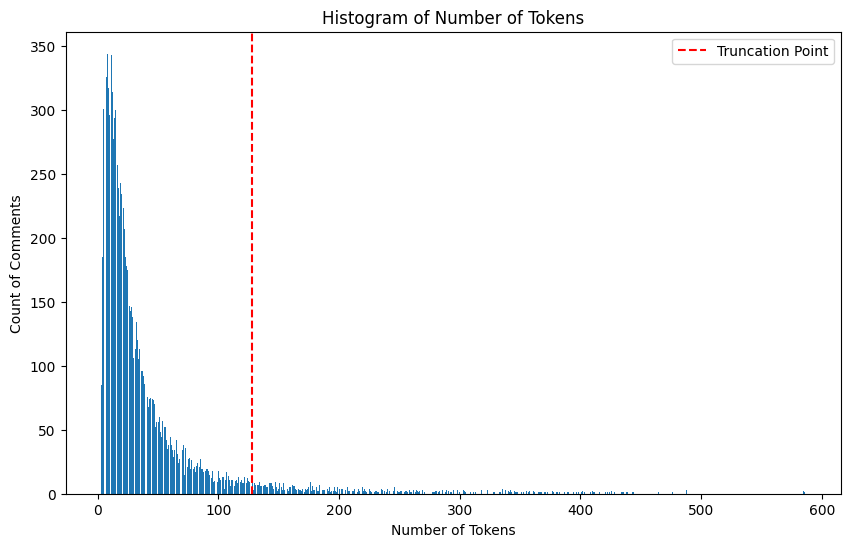

In [14]:
print("\n")

num_tokens = list(num_tokens_count_dict.keys())
counts = list(num_tokens_count_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(num_tokens, counts)
plt.axvline(x=max_length, color='red', linestyle='--', label='Truncation Point')

plt.xlabel('Number of Tokens')
plt.ylabel('Count of Comments')
plt.title('Histogram of Number of Tokens')
plt.legend()

plt.show()

print("\n")

## Use LLM to perform Sentiment Analysis

This part will take a while...

In [15]:
print("\n")

post_bin_datetime_list = []
post_bin_sentiment_score_list = []
post_bin_normalised_sentiment_score_list = []

for bin_datetime, comments in binned_datetime_comments_dict.items():

    if bin_datetime in overlapped_presaved_datetime_dict:
        continue

    print("Performing sentiment analysis on comments in Date Time {} bin...".format(bin_datetime))
    
    sentiment_preds = pipe(comments)
    bin_sentiment_score = 0
    
    for sentiment_pred in sentiment_preds:
        if sentiment_pred['label'].lower() == 'bullish':
            bin_sentiment_score += sentiment_pred['score']
        elif sentiment_pred['label'].lower() == 'bearish':
            bin_sentiment_score -= sentiment_pred['score']

    bin_normalised_sentiment_score = bin_sentiment_score / len(sentiment_preds)

    post_bin_datetime_list.append(bin_datetime)
    post_bin_sentiment_score_list.append(bin_sentiment_score)
    post_bin_normalised_sentiment_score_list.append(bin_normalised_sentiment_score)

print("\n")



Performing sentiment analysis on comments in Date Time 2024-08-05 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-06 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-07 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-08 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-09 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-10 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-11 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-12 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-13 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-14 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-15 00:00:00 bin...
Performing sentiment analysis on comments in Date Time 2024-08-16 00:00:00 bin...
Performing sen

## Save and Check Sentiment Score Data

### Sentiment Score

In [16]:
print("\n")

binned_sentiment_score_df = pd.DataFrame({
    'Open Time': post_bin_datetime_list,
    'Sentiment Score': post_bin_sentiment_score_list
})

dir_path = './saved_data/sentiment_score/{}/{}/{}'.format(source, board, cex + '_' + interval)
binned_sentiment_score_df = save_sentiment_score_df(binned_sentiment_score_df, dir_path, start_date, end_date)
binned_sentiment_score_df = binned_sentiment_score_df.set_index('Open Time')

print("Sentiment Score:")
print(binned_sentiment_score_df.head(5))
print(binned_sentiment_score_df.tail(5))

print("\n")



Deleted: ./saved_data/sentiment_score/4chan/biz/binance_1d/2024-08-05 00:00:00_2024-08-17 00:00:00.pkl


Sentiment Score:
            Sentiment Score
Open Time                  
2024-08-05         3.462021
2024-08-06         7.064243
2024-08-07        12.968785
2024-08-08        37.219695
2024-08-09       127.480316
            Sentiment Score
Open Time                  
2024-08-13        24.884155
2024-08-14        47.127808
2024-08-15        60.855924
2024-08-16       127.745349
2024-08-17       128.934411




### Normalised Sentiment Score

In [17]:
print("\n")

binned_normalised_sentiment_score_df = pd.DataFrame({
    'Open Time': post_bin_datetime_list,
    'Sentiment Score': post_bin_normalised_sentiment_score_list
})

dir_path = './saved_data/normalised_sentiment_score/{}/{}/{}'.format(source, board, cex + '_' + interval)
binned_normalised_sentiment_score_df = save_sentiment_score_df(binned_normalised_sentiment_score_df, dir_path, start_date, end_date)
binned_normalised_sentiment_score_df = binned_normalised_sentiment_score_df.set_index('Open Time')

print("Normalised Sentiment Score:")
print(binned_normalised_sentiment_score_df.head(5))
print(binned_normalised_sentiment_score_df.tail(5))

print("\n")





Normalised Sentiment Score:
            Sentiment Score
Open Time                  
2024-08-05         0.432753
2024-08-06         0.050822
2024-08-07         0.078599
2024-08-08         0.086759
2024-08-09         0.093598
            Sentiment Score
Open Time                  
2024-08-13         0.113110
2024-08-14         0.090980
2024-08-15         0.096444
2024-08-16         0.078613
2024-08-17         0.095155




In [18]:
print("\nSelectable pairs:")

for pair in sorted_available_pairs:
    print("- {}".format(pair))

print("\n")


Selectable pairs:
- 1000FLOKIUSDT
- 1000LUNCUSDT
- 1000PEPEUSDT
- 1000SHIBUSDT
- 1INCHUSDT
- AAVEUSDT
- ADAUSDT
- ALGOUSDT
- AMBUSDT
- ANKRUSDT
- APEUSDT
- APTUSDT
- ARBUSDT
- ARKMUSDT
- ARUSDT
- ASTRUSDT
- ATOMUSDT
- AVAXUSDT
- AXSUSDT
- BAKEUSDT
- BANDUSDT
- BCHUSDT
- BLURUSDT
- BNBUSDT
- BNXUSDT
- BTCUSDT
- CELOUSDT
- CFXUSDT
- CHZUSDT
- CKBUSDT
- COMPUSDT
- CRVUSDT
- DOGEUSDT
- DOTUSDT
- DYDXUSDT
- ENSUSDT
- EOSUSDT
- ETCUSDT
- ETHUSDT
- FETUSDT
- FILUSDT
- FLOWUSDT
- FTMUSDT
- GALAUSDT
- GMTUSDT
- GMXUSDT
- GRTUSDT
- HBARUSDT
- HIGHUSDT
- HOOKUSDT
- ICPUSDT
- IMXUSDT
- INJUSDT
- JASMYUSDT
- LDOUSDT
- LINAUSDT
- LINKUSDT
- LPTUSDT
- LTCUSDT
- MANAUSDT
- MASKUSDT
- MATICUSDT
- MAVUSDT
- MINAUSDT
- MKRUSDT
- NEARUSDT
- NEOUSDT
- OPUSDT
- PENDLEUSDT
- PEOPLEUSDT
- QTUMUSDT
- REEFUSDT
- RSRUSDT
- RUNEUSDT
- SANDUSDT
- SEIUSDT
- SNXUSDT
- SOLUSDT
- SSVUSDT
- STGUSDT
- STMXUSDT
- STORJUSDT
- STXUSDT
- SUIUSDT
- SUSHIUSDT
- THETAUSDT
- TRBUSDT
- TRXUSDT
- TUSDT
- UMAUSDT
- UNFIUSDT
- UNI

## Select Pairs for Detailed Analysis

- Please select any pair combination from the output below.

### Inputs

In [19]:
##### INPUTS #####
ticker_pairs = ["BTCUSDT", "ETHUSDT", "SOLUSDT"]
##################

## Plot Function

Bullish sentiment is highlighted in the chart as green and bearish sentiment is highlighted in the chart as red. The alpha of the colours (opacity) represent the score of the sentiment. The higher the sentiment score, the higher the alpha value of the color (more opaque).

In [20]:
def plot_sentiment_on_chart(ticker_pairs, price_data_sanitized, binned_sentiment_score_df):
    fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
    if len(ticker_pairs) == 1:
        axs = [axs]
    
    for i, ticker in enumerate(ticker_pairs):
    
        if ticker not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker))
            continue
    
        price_data = price_data_sanitized[ticker]['Close']
        open_time = price_data_sanitized[ticker].index
        sentiment_score = binned_sentiment_score_df['Sentiment Score']
        sentiment_score = sentiment_score.reindex(open_time)
        sentiment_score = sentiment_score.fillna(0)
        max_abs_sentiment_score = sentiment_score.abs().max()
        sentiment_score_normalized = (sentiment_score / max_abs_sentiment_score) * 0.5
        
        axs[i].plot(open_time, price_data, label=f'{ticker}', color='gray', alpha=0.7)
    
        # Apply rolling mean with a window of 15
        price_data_smooth = price_data.rolling(window=15, min_periods=1).mean()
        axs[i].plot(open_time, price_data_smooth, label=f'{ticker} SMA', color='blue')
    
        if len(open_time) > 1:
            # Plot sentiment score regions
            for j in range(len(sentiment_score_normalized) - 1):
                start_time = open_time[j]
                end_time = open_time[j + 1]
                
                if sentiment_score_normalized.iloc[j] > 0:
                    axs[i].axvspan(start_time, end_time, color='green', alpha=sentiment_score_normalized.iloc[j])
                elif sentiment_score_normalized.iloc[j] < 0:
                    axs[i].axvspan(start_time, end_time, color='red', alpha=abs(sentiment_score_normalized.iloc[j]))
        
            # Handling the last bin if necessary
            last_time = open_time[-1]
            next_time = last_time + (open_time[-1] - open_time[-2])  # Assumes last bin has the same duration
            if sentiment_score_normalized.iloc[-1] > 0:
                axs[i].axvspan(last_time, next_time, color='green', alpha=sentiment_score_normalized.iloc[-1])
            elif sentiment_score_normalized.iloc[-1] < 0:
                axs[i].axvspan(last_time, next_time, color='red', alpha=abs(sentiment_score_normalized.iloc[-1]))
    
        green_patch = mpatches.Patch(color='green', label='Bullish Sentiment')
        red_patch = mpatches.Patch(color='red', label='Bearish Sentiment')
    
        handles, labels = axs[i].get_legend_handles_labels()
        handles.extend([green_patch, red_patch])
        labels.extend(['Bullish Sentiment', 'Bearish Sentiment'])
    
        axs[i].set_ylabel('Price ($)', fontsize=18)
        axs[i].set_xlabel('Open Time', fontsize=18)
        axs[i].set_title(f'{ticker}', fontsize=24)
        axs[i].legend(handles=handles, labels=labels, loc='best')
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

### Sentiment Score

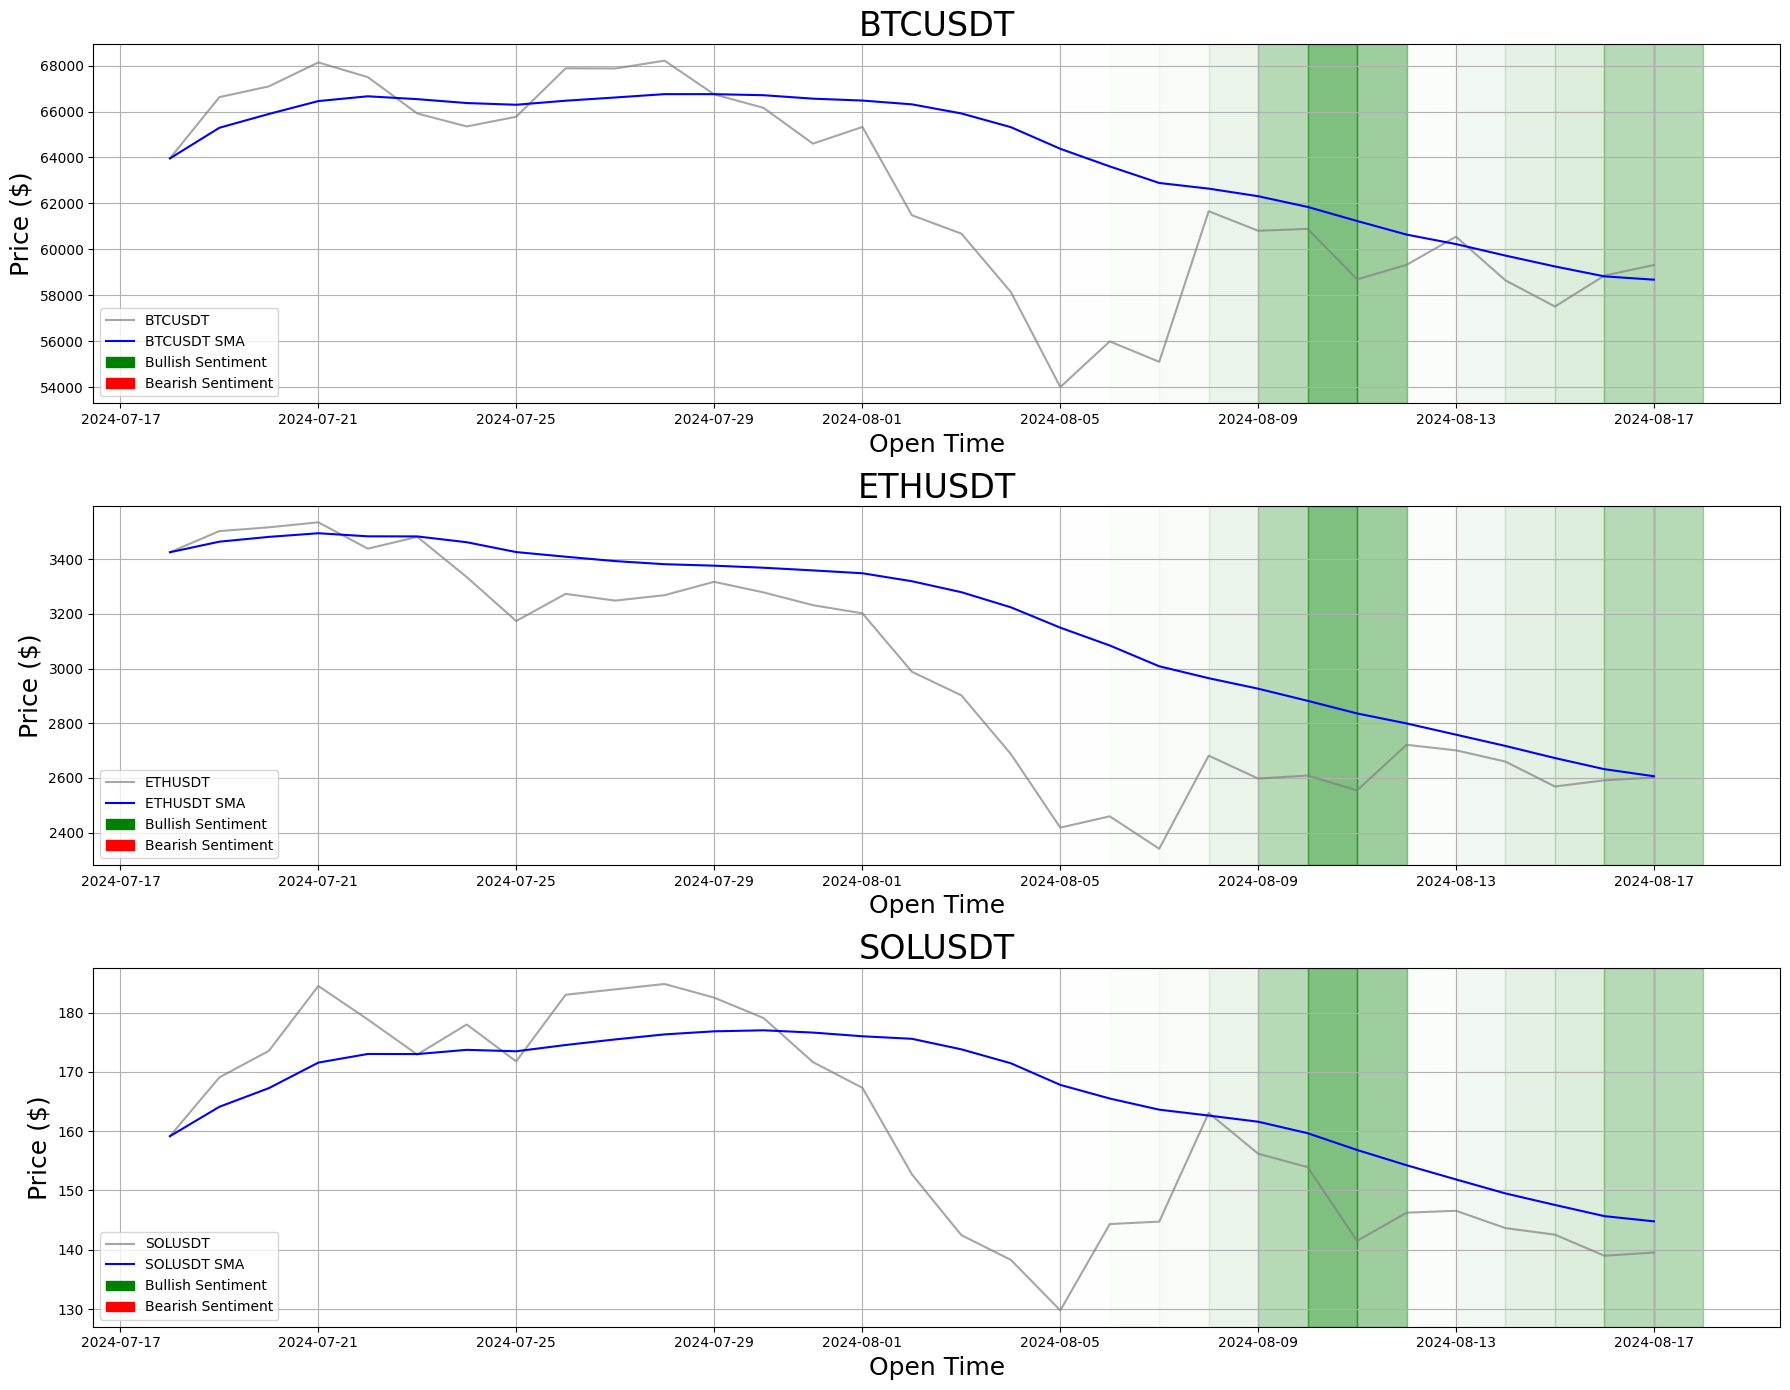

In [21]:
print("\n")

plot_sentiment_on_chart(ticker_pairs, price_data_sanitized, binned_sentiment_score_df)

print("\n")

### Normalised Sentiment Score

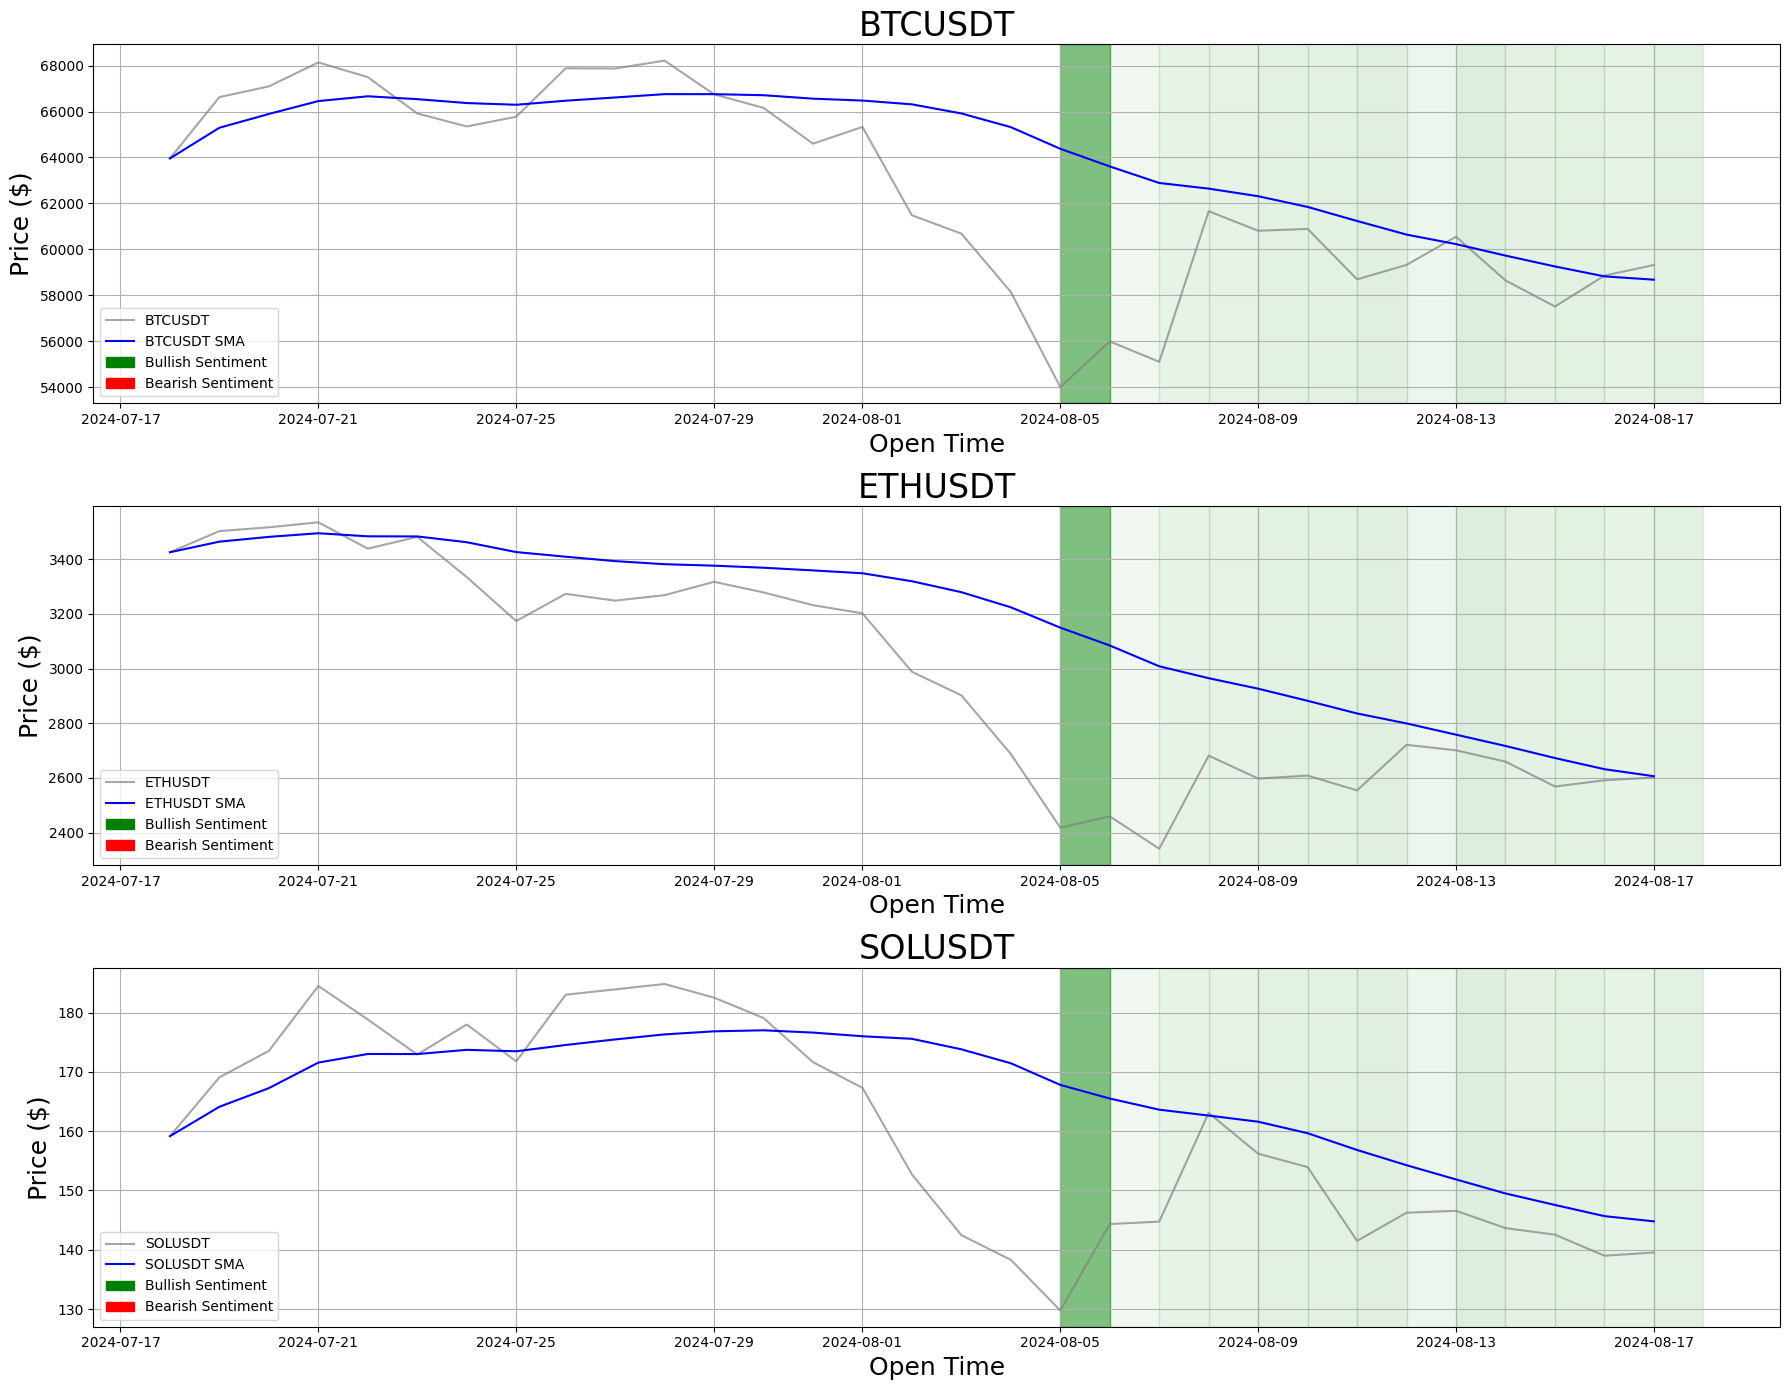

In [22]:
print("\n")

plot_sentiment_on_chart(ticker_pairs, price_data_sanitized, binned_normalised_sentiment_score_df)

print("\n")